In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
import numpyro  

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

def default_axis(figsize = (6,4.5), 
               xlabel: str = None,
               ylabel: str = None,
               labelsize: int = 10,
               fontsize: int = 11,
               ax: plt.Axes = None,
               n_minor_ticks: int = 5):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    
    ax.set_xlabel(xlabel,fontsize = 10)
    ax.set_ylabel(ylabel,fontsize  = fontsize)
    ax.tick_params('both',labelsize = labelsize,direction = 'in',which = 'both')

    ax.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks))
    
    return fig,ax

c:\Users\mlanahan3\Anaconda3\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### The Statistical Model

We suppose that the recrystillization fraction _X(T,t)_ may be modeled using a (generalized) logistic growth function. The temperature dependence follows through the Arrhenius process modeled for the growth rate $B$ and starting time $M$.

$
X = \frac{1}{(1 + e^{-B (t - M)})^{1/\nu}} \\ 
B = A_1 \exp{\left(-B_1/T \right)} \\ 
M = A_2 \exp{\left(B_2/T \right)} \\ 
$

### Visualizing the Data

Showing the response of the recrstillization fraction to time at a specific temperature.

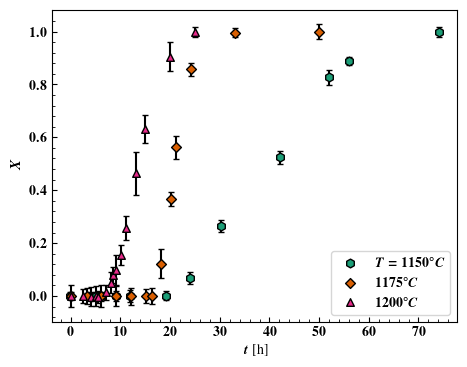

In [2]:
data = pd.read_csv('rf_data/alfonso_data/highly_rolled.csv',index_col = 0)

temps = [1150,1175,1200]
fig,ax = default_axis(figsize = (4.5,3.5),
                      xlabel = r'$t$ [h]',
                      ylabel = r'$X$')
colors = plt.get_cmap('Dark2')([0.1,0.2,0.4])
markers = ['h','D','^']
sizes = [40,25,30]
labels = [r'$T = 1150 ^\circ C$',r'$1175 ^\circ C$',r'$1200 ^\circ C$']
for marker,color,T,label,size in zip(markers,colors,temps,labels,sizes):
    df = data.loc[data['temperature'] == T]

    ax.errorbar(df['time'],df['X'].to_numpy(),yerr = df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
    ax.scatter(df['time'],df['X'],facecolor  = color,edgecolor = 'k',
            lw = 1.0,s = size,marker = marker,zorder = 1000,label = label)

#ax.set_xlim
ax.legend(loc = 'best',fontsize = 10)
fig.tight_layout(pad = 0.1)
fig.savefig('images/rolled_data_example.svg',dpi = 300)

## Preliminary Model Analysis

### Starting Time Arrenhius Process

With nonlinear regression we'll need to use some sort of general nonlinear optimization technique. If we can get some initial estimates for what those parameters may be, this will improve our ablity to best fist the model by reducing the parameter search space.

The parameter $M$ corresponds to some "starting" time, which we can visually identify as the flat portions of the curves in the above figure. With $X(M) = 1/2^{1/\nu} = X_{\varepsilon}$. We want $X_{\varepsilon}$ to be small ($\sim 0.01$), reflecting that prior to this value we don't consider the process to have "started". This implies that:

$
\nu = \frac{\ln{X_{\varepsilon}}}{\ln{2}}
$

where $0 < X_{\varepsilon} < 1$, which is a useful reparameterization of the model. To interpret this:

$
X_{\varepsilon} = 1e-4 \implies =\nu = 13.3 \\ 
X_{\varepsilon} = 1e-1 \implies =\nu = 3.3
$

Taking the log of both sides of the Arrhenius function yields

$ln{M} = \frac{-B_2}{T} + \ln{A_2}$



2.0686576104190406
Full Data Fit
logA2: -12.23 lower: -66 upper: 2
B2: 36585.35 lower: 29879.25 upper: 43291.44
Lopez Data Fit
logA2: -26.35 lower: -66 upper: 3
B2: 60263.56 lower: 48065.63 upper: 72461.5


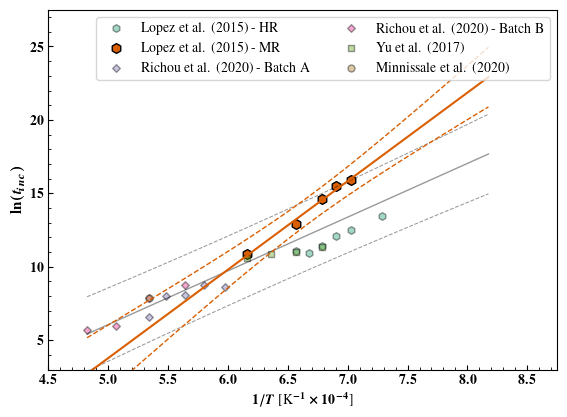

In [3]:
import scipy
from typing import Tuple, List
import math

def estimate_tinc(data: pd.DataFrame,
                  thresh: float = 0.02):
    
    index = data['X'] > thresh
    tinc = data.loc[index,'time'].max()
    return tinc

def get_tinc_estimates(df: pd.DataFrame,thresh: float = 0.02) -> pd.DataFrame:
    temperatures = df['temperature'].unique()
    tinc = []
    for T in temperatures:
        data = df.loc[df['temperature'] == T]
        tinc.append(estimate_tinc(data,thresh)) 
        
    return pd.DataFrame(np.array([temperatures,tinc]).T,columns = ['temperature','tinc'])


def estimate_incubation_time_function(data_set: List[pd.DataFrame],
                                      thresh: float = 0.02) -> Tuple[float]:

    all_tinc = []
    for data in data_set:
        tinc = get_tinc_estimates(data,thresh = thresh)
        all_tinc.append(tinc)
    
    tinc = pd.concat(all_tinc)
    x = 1./tinc['temperature']
    y= np.log(tinc['tinc'])
    S_xx = np.sum((x - x.mean())**2)
    S_xy = np.sum((x - x.mean())*(y - y.mean()))
    beta_1 = S_xy/S_xx
    beta_0 = y.mean() - beta_1*x.mean()
    b2 = beta_1
    a2 = math.exp(beta_0)

    residuals = y - (beta_0 + beta_1*x)

    return a2,b2,S_xx,S_xy,residuals,x

data_file = ['rf_data/alfonso_data/highly_rolled.csv',
             'rf_data/alfonso_data/moderate_roll.csv',
             'rf_data/richou_data/batch_a_data.csv',
             'rf_data/richou_data/batch_b_data.csv',
             'rf_data/yu_data/data.csv',
             'rf_data/minnessale_data/data.csv']

labels = ['Lopez et al. (2015) - HR',
          'Lopez et al. (2015) - MR',
          'Richou et al. (2020) - Batch A',
          'Richou et al. (2020) - Batch B',
          'Yu et al. (2017)',
          'Minnissale et al. (2020)']

multiplier = [3600,3600,1,1,3600,1]
markers = ['h','h','D','D','s','o']
sizes = [30,50,15,15,20,25]
colors = plt.get_cmap('Dark2')([0.1,0.2,0.3,0.4,0.6,0.8])

fig,ax = default_axis(figsize = (5.5,4.0),
                      xlabel = r'$1/T$ [K$^{-1} \times 10^{-4}$]',
                      ylabel= r'$\ln(t_{inc})$')

## plot full data set
dataset = []
for i,file in enumerate(data_file):
    data = pd.read_csv(file,index_col = 0)
    data['temperature'] += 273.15
    data['time'] *= multiplier[i]
    dataset.append(data)
    tinc = get_tinc_estimates(data,thresh = 0.02)
    ax.scatter(1/tinc['temperature']*1e4,np.log(tinc['tinc']),facecolor = colors[i],edgecolor = 'k',
               lw = 1.0,s = sizes[i],marker = markers[i],label = labels[i],alpha = 0.4 if 'MR' not in labels[i] else 1.0)

a2,b2,S_xx,S_xy,resid,x = estimate_incubation_time_function(dataset)

S2 = np.sum(resid**2)/(resid.shape[0] - 2)

xplot = np.linspace(x.min(),1/(950 + 273.15),100)
yhat = b2*xplot + math.log(a2)
t_alpha = scipy.stats.t.ppf(1 - 0.05/2,resid.shape[0] - 2)
print(t_alpha)
ci_yhat = t_alpha * S2**0.5 * np.sqrt(1.  + 1/resid.shape[0] + (xplot - x.mean())**2 / S_xx)

a2_se = (S2*(1/x.shape[0] + x.mean()**2/S_xx))**0.5
b2_se = (S2/S_xx)**0.5  
upper = yhat + ci_yhat
lower = yhat - ci_yhat

ax.plot(xplot*1e4,yhat,color = 'k',lw = 1.,alpha = 0.4)
ax.plot(xplot*1e4,lower,color = 'k',lw = 0.75,ls = '--',alpha = 0.4)
ax.plot(xplot*1e4,upper,color = 'k',lw = 0.75,ls = '--',alpha = 0.4)

print('Full Data Fit')
print(f'logA2: {round(math.log(a2),2)} lower: {round(math.log(max(a2 - t_alpha*a2_se,1e-20),2))} upper: {round(math.log(a2 + t_alpha*a2_se,2))}')
print(f'B2: {round(b2,2)} lower: {round(b2 - t_alpha*b2_se,2)} upper: {round(b2 + t_alpha*b2_se,2)}')


## fit only to the medium rolled lopez et al data
dataset = []
for i,file in enumerate(['rf_data/alfonso_data/moderate_roll.csv']):
    data = pd.read_csv(file,index_col = 0)
    data['temperature'] += 273.15
    data['time'] *= multiplier[i]
    dataset.append(data)

a2_l,b2_l,S_xx_l,S_xy_l,resid_l,x_l = estimate_incubation_time_function(dataset)

S2_l = np.sum(resid_l**2)/(resid_l.shape[0] - 2)

yhat_l = b2_l*xplot + math.log(a2_l)
ci_yhat_l = scipy.stats.t.ppf(1 - 0.05/2,resid_l.shape[0] - 2) * S2_l**0.5 * np.sqrt(1.  + 1/resid_l.shape[0] + (xplot - x_l.mean())**2 / S_xx_l)

upper_l = yhat_l + ci_yhat_l
lower_l = yhat_l - ci_yhat_l

a2_l_se = (S2_l*(1/x_l.shape[0] + x_l.mean()**2/S_xx_l))**0.5
b2_l_se = (S2_l/S_xx_l)**0.5  
t_alpha = scipy.stats.t.ppf(1 - 0.05/2,resid_l.shape[0] - 2)
ax.plot(xplot*1e4,yhat_l,lw = 1.5,color = plt.get_cmap('Dark2')(0.2))
ax.plot(xplot*1e4,lower_l,lw = 1.0,ls = '--',color = plt.get_cmap('Dark2')(0.2))
ax.plot(xplot*1e4,upper_l,lw = 1.0,ls = '--',color = plt.get_cmap('Dark2')(0.2))

print('Lopez Data Fit')
print(f'logA2: {round(math.log(a2_l),2)} lower: {round(math.log(max(a2_l - t_alpha*a2_l_se,1e-20),2))} upper: {round(math.log(a2_l + t_alpha*a2_l_se,2))}')
print(f'B2: {round(b2_l,2)} lower: {round(b2_l - t_alpha*b2_l_se,2)} upper: {round(b2_l + t_alpha*b2_l_se,2)}')

ax.set_ylim([3,27.5])
ax.set_xlim([4.5,8.75])
ax.legend(loc = 'best',fontsize = 10,ncols = 2)
fig.tight_layout(pad = 0.1)
fig.savefig('images/tinc_vs_T_data_lopez_mr.svg')

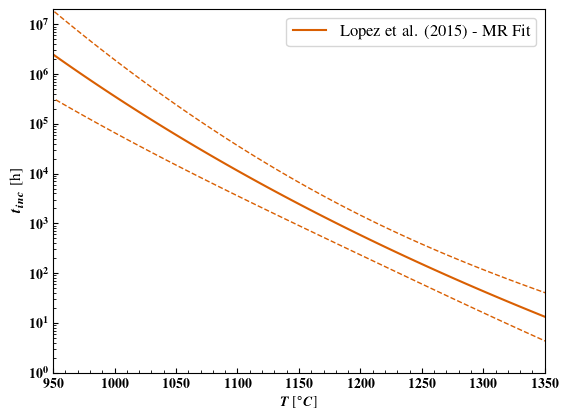

### Visualizing the Latent Functions
$
\ln{B} = \frac{B_2}{T} + A_2 \\ 
\ln{(1 - X)} = -b^{n}(t - t_{inc})^n \\ 
\ln{\ln{(1 - X)}} = n\ln{-b} + \ln{(t- t_{inc})} \\ 
b = -\exp{\left(\frac{\ln{\ln{(1 - X)}} - \ln{(t- t_{inc})}}{n}\right)}
$

logA1: -16.96 B1: 44044.03


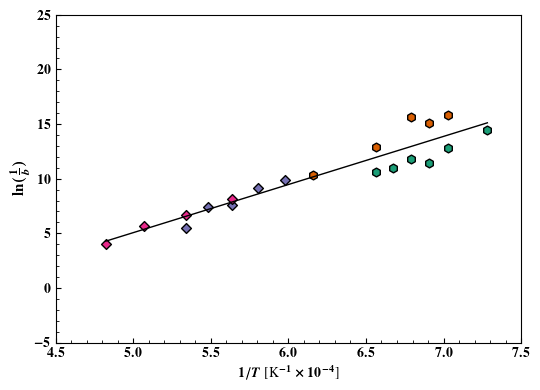

In [4]:
def estimate_tinc(data: pd.DataFrame,
                  thresh: float = 0.02):
    
    index = data['X'] > thresh
    tinc = data.loc[index,'time'].max()
    return tinc

def get_tinc_estimates(df: pd.DataFrame,thresh: float = 0.02) -> pd.DataFrame:
    temperatures = df['temperature'].unique()
    tinc = []
    for T in temperatures:
        data = df.loc[df['temperature'] == T]
        tinc.append(estimate_tinc(data,thresh)) 
        
    return pd.DataFrame(np.array([temperatures,tinc]).T,columns = ['temperature','tinc'])

data_file = ['rf_data/alfonso_data/highly_rolled.csv',
             'rf_data/alfonso_data/moderate_roll.csv',
             'rf_data/richou_data/batch_a_data.csv',
             'rf_data/richou_data/batch_b_data.csv']

multiplier = [3600,3600,1,1]
markers = ['h','h','D','D']
sizes = [40,40,25,25]
colors = plt.get_cmap('Dark2')([0.1,0.2,0.3,0.4])

fig,ax = default_axis(figsize = (5.5,4.0),
                      xlabel = r'$1/T$ [K$^{-1} \times 10^{-4}$]',
                      ylabel= r'$\ln(\frac{1}{b})$')

all_y = []
all_x = []
temperatures = [] 
n = 1.1
for i,file in enumerate(data_file):
    data = pd.read_csv(file,index_col = 0)
    data['temperature'] += 273.15
    data.loc[:,'time'] *= multiplier[i]
    tinc = get_tinc_estimates(data,thresh = 0.02)
    for temp in tinc:
        data.loc[data['temperature'] == temp,'time'] -= tinc.loc[tinc['temperature'] == temp,'tinc']

    data = data.loc[data['time'] > 0]
    temperatures.append(data['temperature'].values)
    data.loc[data['X'].to_numpy() >= 1.0,:] = 1.0 - 1e-4
    data.loc[data['X'].to_numpy() <=  0,:] = 1e-4
    y = 1/n*np.log(data['time'].values**n/np.log(1/(1-data['X'].values)))
    yy = []
    for temp in tinc['temperature']:
        index = data['temperature'] == temp
        yy.append(y[index].mean())        

    all_y.append(yy)
    all_x.append(1/tinc['temperature'].to_numpy())
    ax.scatter(1/tinc['temperature']*1e4,yy,facecolor = colors[i],edgecolor = 'k',
               lw = 1.0,s = sizes[i],marker = markers[i],label = file.split('/')[-1].split('.')[0])

x = np.concatenate(all_x)
y= np.concatenate(all_y)
S_xx = np.sum((x - x.mean())**2)
S_xy = np.sum((x - x.mean())*(y - y.mean()))
beta_1 = S_xy/S_xx
beta_0 = y.mean() - beta_1*x.mean()

b2,a2 = np.polyfit(x,y,1)
xplot = np.linspace(x.min(),x.max(),100)
ax.plot(xplot*1e4,b2*xplot + a2,color = 'k',lw = 1.0)

print(f'logA1: {round(a2,2)} B1: {round(b2,2)}')
ax.set_ylim([-5,25])
ax.set_xlim([4.5,7.5])
fig.tight_layout()

### Point Estimation via Nonlinear Least Squares

We can use a nonlinear least squares method to estimate the parameters $(K,n, t_{inc})$. The problem is, we're not incorporating the  _uncertainty_ in our data, so points that saw significant spread during data influence the model just as points we are more sure about. We can rectify this using _weighted least squares_. As shown by the plot below, there isn't a significant change in the model prediction, but there is an enourmous change in the model _parameters_.

In [7]:
from scipy.optimize import differential_evolution
from typing import Callable, Tuple
from dataclasses import dataclass
import math
import warnings


def jmak_model(t: np.ndarray,b: float,t_inc: float,n: float):
    1.0 - np.exp(-b**n*(t - t_inc)**n)
    yhat = np.empty_like(t)
    index = t >= t_inc
    yhat[~index] = 0
    yhat[index] = 1.0 - np.exp(-b[index]**n*(t[index]-t_inc[index])**n)
    return yhat


def generalized_logistic(t: np.ndarray,B: float,M: float,nu: float):
    return 1/(1 + np.exp(-B*(t - M)))**(1/nu)

class GeneralizedLogistic:
    
    def __call__(self,t: np.ndarray,B: float,M: float,nu: float):
        return generalized_logistic(t,B,M,nu)
    
    def dXdB(self,t: np.ndarray,B: float,M: float,nu: float):
        return (t - M)*np.exp(-B*(t - M))/(nu *(1 + np.exp(-B*(t - M)))**(1/nu + 1))
    
    def dXdM(self,t: np.ndarray,B: float,M: float,nu: float):
        return B*np.exp(-B*(t - M))/(nu *(1 + np.exp(-B*(t - M)))**(1/nu + 1))
    
    def dXdnu(self,t: np.ndarray,B: float,M: float,nu: float):
        return -np.log(1 + np.exp(-B*(t - M)))/(nu**2*(1 + np.exp(-B*(t - M)))**(1/nu + 1))
    
    def grad(self,t: np.ndarray,B: float,M: float,nu: float):
        return np.array([self.dXdB(t,B,M,nu),self.dXdM(t,B,M,nu),self.dXdnu(t,B,M,nu)])
    
@dataclass
class ModelFunc:
    
    rxFunc: Callable
    n: float
    A1: float
    A2: float
    B1: float
    B2: float
    
    def __call__(self,t: np.ndarray, T: np.ndarray):
        return self._func(self.rxFunc,t,T,self.n,self.A1,self.A2,self.B1,self.B2)

    @staticmethod
    def _func(rxFunc: Callable,
              t: np.ndarray,
              T: np.ndarray,
              n: float,
              A1: float,
              A2: float,
              B1: float,
              B2: float):
        
        b = A1*np.exp(-B1/T)
        t_inc = A2*np.exp(B2/T)
        return rxFunc(t,b,t_inc,n)
    

    @staticmethod   
    def get_opt_params(fixed_params: dict,bounds: np.ndarray):
        opt_params = {'n':0,'A1':1,'A2':2,'B1':3,'B2':4}
        fi,fp = np.zeros(5,dtype = bool),[]
        for key in fixed_params:
            if key not in opt_params:
                raise ValueError(f'Invalid fixed parameter: {key}')
            
            fi[opt_params[key]] = True
            fp.append(fixed_params[key])

        
        if fixed_params:
            _bounds = np.zeros([5,2])
            _bounds[~fi,:] = bounds.copy()
        else:
            _bounds = bounds.copy()
        
        _bounds[1:3,:] = np.log(_bounds[1:3,:])
        
        if fixed_params:
            _bounds = _bounds[~fi,:]

        fi,fp = np.array(fi),np.array(fp)
        return fi,fp,_bounds
        
    @classmethod
    def fit(cls,rxFunc: Callable,
                t: np.ndarray,
                T: np.ndarray,
                X: np.ndarray,
                opt_method: Callable,
                bounds: Tuple[np.ndarray],
                weights: np.ndarray = None,
                fixed_params = {},
                **kwargs):
        
        fi,fp,bounds = cls.get_opt_params(fixed_params,bounds)
        w = np.ones_like(t) if not isinstance(weights,np.ndarray) and weights is None else weights
        w/=np.linalg.norm(w)
        
        def resid_ss(theta: np.ndarray):
            theta[1:3] = np.exp(theta[1:3])
            return np.sum((w*(X - cls._func(rxFunc,t,T,*theta)))**2)
        
        def resid_ss_fp(theta: np.ndarray):
            _theta = np.zeros(5)
            _theta[fi] = fp
            _theta[~fi] = theta
            return resid_ss(_theta)
        
        if fixed_params:
            opt_res = opt_method(resid_ss_fp,bounds,**kwargs)
            x = np.zeros(5)
            x[fi] = fp
            x[~fi] = opt_res.x

        else:
            opt_res = opt_method(resid_ss,bounds,**kwargs)
            x = opt_res.x.copy()
        
        if opt_res.success:
            x[1:3] = np.exp(x[1:3]) 
            return cls(rxFunc,*x)
        else:
            raise ValueError(f'Optimization failed: {opt_res.message}')
        
        
df = pd.concat([pd.read_csv('rf_data/alfonso_data/highly_rolled.csv',index_col = 0)])


df['time']*=3600
t = df['time'].to_numpy()
T = df['temperature'].to_numpy() + 273.15
X = df['X'].to_numpy()
X[X <= 0 ] = 0.0
X[X >= 1] = 1
with warnings.catch_warnings(action = 'ignore'):
    df.loc[df['std'] == 0,'std'] = max(np.min(df.loc[df['std'] > 0,'std']),0.1e-3)

w = 1/df['std'].to_numpy()**2


lb = np.array([])
bounds = np.array([[1e-2,math.exp(16.96)*1e-4,1e-20,44044.03/10,29879.25/2],
                   [1,math.exp(16.96)*1e4,math.exp(3)*1e2,44044.03*10,72461.5*2]]).T
model = ModelFunc.fit(generalized_logistic,t,T,X,differential_evolution,bounds.copy(),maxiter = 10000,tol = 1e-6)
model_weighted = ModelFunc.fit(generalized_logistic,t,T,X,differential_evolution,bounds.copy(),
                               weights = w,maxiter = 10000,tol = 1e-6)

print('Unweighted Estimate')
print(f'n: {round(model.n,2)}, A1: {round(model.A1,2)}, A2: {round(model.A2,10)}, B1: {round(model.B1,2)}, B2: {round(model.B2,2)}')

print('Weighted Estimate')
print(f'n: {round(model_weighted.n,2)}, A1: {round(model_weighted.A1,2)}, A2: {round(model_weighted.A2,2)}, B1: {round(model_weighted.B1,2)}, B2: {round(model_weighted.B2,2)}')





C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_81060\940264403.py:18: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-B*(t - M)))**(1/nu)
C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_81060\940264403.py:18: RuntimeWarning: overflow encountered in power
  return 1/(1 + np.exp(-B*(t - M)))**(1/nu)


Unweighted Estimate
n: 0.02, A1: 2517029.7, A2: 0.0, B1: 35446.84, B2: 72189.58
Weighted Estimate
n: 0.14, A1: 7204679.52, A2: 0.0, B1: 228491.23, B2: 86928.75


### Visualize The Model Response

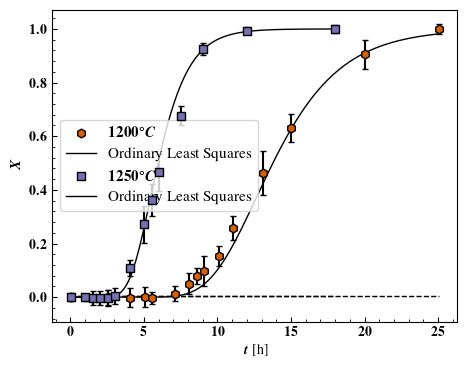

In [10]:
data = pd.read_csv('rf_data/alfonso_data/highly_rolled.csv',index_col = 0)
fig,ax = default_axis(figsize = (4.5,3.5),
                    xlabel = r'$t$ [h]',
                    ylabel = r'$X$')
for marker,color,T_plot in zip(['h','s'],plt.get_cmap('Dark2')([0.2,0.3]),[1200,1250]):
    df = data.loc[data['temperature'] == T_plot]

    ax.errorbar(df['time'],df['X'].to_numpy(),yerr = df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
    ax.scatter(df['time'],df['X'],facecolor  = color,edgecolor = 'k',
            lw = 1.0,s = 40,marker = marker,zorder = 1000, 
            label = rf'$T = {T_plot} ^\circ C$' if i == 0 else rf'${T_plot} ^\circ C$') 

    tplot = np.linspace(0,df['time'].max()*3600,1000)
    ax.plot(tplot/3600,model(tplot,np.ones_like(tplot)*(T_plot +273.15)),color = 'k',lw = 1.,label = 'Ordinary Least Squares')
    ax.plot(tplot/3600,model_weighted(tplot,np.ones_like(tplot)*(T_plot +273.15)),color = 'k',lw = 1.0,ls = '--')

ax.legend(fontsize = 11)
fig.tight_layout(pad = 0.1)
fig.savefig('images/data_fit_example.svg')

### Interval Estimation

The primary issue with the least square approach here is that we don't have any confidence intervals on our parameter estimates. As we see in the difference between the point estimates for the ordinary and weighted least squares estimates, they can vary substantially while still predicting effectively the same model response. Unfortunatley, no closed form solution exists for these distributions. 

We can, however, use the bayesian approach, using the gaussian likelihood implied by the above model:

$
p(K,n,t_{inc} | \mathbf{t}, \mathbf{X}) \propto \mathcal{L}(\mathbf{t}, \mathbf{X}| K,n,t_{inc})p(K,n,t_{inc}) \\ 
\mathcal{L}(\mathbf{t}, \mathbf{X}| K,n,t_{inc}) = \frac{1}{(2\pi)^{n/2} |\mathbf{\Sigma}|} \exp{\left(-\frac{1}{2}(\left(\mathbf{X} - f(\mathbf{t};K,n,t_{inc})\right)^T \mathbf{\Sigma}^{-1} \left(\mathbf{X} - f(t;K,n,t_{inc}\right)\right)}
$

This leaves us with having to specify the prior $p(K,n,t_{inc})$. We see from the least squares above that $K << 1$, and further that $t_{inc} < \text{max}_i{t_i}$ and from the literature we can determine that $0 < n \leq 5$. Finally, the parameters should be positive, and further assuming independence:

$
p(K,n,t_{inc}) = p(K)p(n)p(t_{inc}) \\ 
p(K) \sim \mathcal{U}((0,1]) \qquad p(n) \sim \mathcal{U}([0,5]) \qquad p(t_{inc}) \sim \mathcal{U}([0,\text{max}_i{t_i}])
$

In [37]:
from jax import random, vmap
import jax
import jax.numpy as jnp
from numpyro.distributions import MultivariateNormal, Normal
from numpyro.infer import init_to_value

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

def kernel(X: jnp.ndarray, 
           Z: jnp.ndarray, 
           sigma: float, 
           length: jnp.ndarray,
           noise: jnp.ndarray = None, 
           include_noise=True,
           jitter: float = 1e-4):
    
    deltaXsq = jnp.power((X[..., jnp.newaxis] - Z) / length, 2.0)
    k = sigma**2 * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k = jnp.fill_diagonal(k,k.ravel()[::k.shape[0] + 1] + (noise + jitter),inplace = False)
    
    return k


def model_func(t: np.ndarray,K: float,n: float,t_inc: float):        
        return 1.0 - jnp.exp(-K**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)

def bayesian_gp_model(t: jnp.ndarray = None,
                      X: jnp.ndarray = None,
                      noise: jnp.ndarray= None):
    
    if t is None:
         raise ValueError('t must be provided')

    K = numpyro.sample('K',numpyro.distributions.Uniform(1e-5,1e-2))
    n = numpyro.sample('n',numpyro.distributions.Uniform(1,4.5))
    t_inc = numpyro.sample('t_inc',numpyro.distributions.Uniform(0,t.max()/2))
    sigma = numpyro.sample('sigma',numpyro.distributions.Exponential(10.0))
    l1 = numpyro.sample('l1',numpyro.distributions.Uniform(t.max()/10,t.max()*10))

    Kernel = kernel(t,t,sigma,l1,noise,include_noise = isinstance(noise,jnp.ndarray))
    
    X_hat = model_func(t,K,n,t_inc)
    numpyro.sample('obs',MultivariateNormal(loc = X_hat, covariance_matrix= Kernel),obs = X)
    

df = pd.read_csv('rf_data/alfonso_data/highly_rolled.csv',index_col = 0)
df = df.loc[df['temperature'] == 1200]
df['time']*=3600
x = df['time'].to_numpy()
y = df['X'].to_numpy()
y[y <= 0 ] = 0.0
y[y >= 1] = 1
noise = df['std'].to_numpy()**2

bounds = np.array([[1e-20,0.0,0],[1,3.0,x.max()/2]]).T
model = ModelFunc.fit(x,y,differential_evolution,bounds.copy(),maxiter = 10000,tol = 1e-10)
model_weighted = ModelFunc.fit(x,y,differential_evolution,bounds.copy(),
                               weights = w,maxiter = 10000,tol = 1e-10)

resid = model_weighted(x) - y
rss = np.sum(w*resid**2)
sigma = np.sqrt(rss/(len(t) - 3))
init_params = {'K':model_weighted.K,'n':model_weighted.n, 't_inc':model_weighted.t_inc,'sigma':sigma,'l1':x.mean()/2}
nuts_kernel = numpyro.infer.NUTS(bayesian_gp_model)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_samples=3000,
    num_warmup=500,
    num_chains= 1,
)

mcmc.run(rng_key_,jnp.array(x),jnp.array(y),noise = jnp.array(noise),
         init_params = init_params)
mcmc.print_summary()
posterior_samples = mcmc.get_samples()


sample: 100%|██████████| 3500/3500 [00:17<00:00, 202.48it/s, 31 steps of size 6.42e-02. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         K      0.00      0.00      0.00      0.00      0.00    845.97      1.00
        l1 470776.06 250401.16 474790.25 117739.16 893911.25   1863.17      1.00
         n      2.70      0.75      2.62      1.57      3.97    679.12      1.00
     sigma      0.03      0.04      0.02      0.00      0.08   1213.16      1.00
     t_inc  16374.28   7159.10  17065.94   4247.23  27255.83    724.50      1.00

Number of divergences: 0


### Visualization of Parameter Posteriors

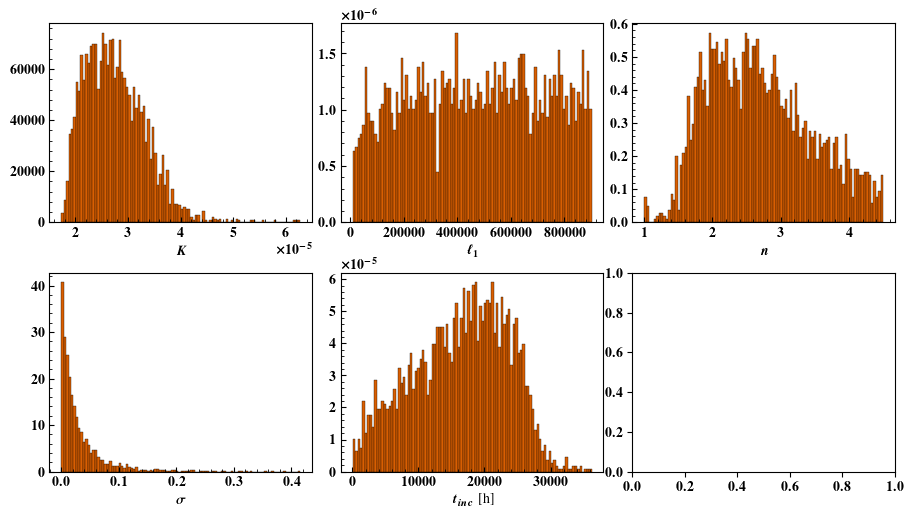

In [38]:
fig,axes = plt.subplots(figsize = (9,5),nrows = 2,ncols = 3)
xlabels = {'K':r'$K$','n':r'$n$','t_inc':r'$t_{inc}$ [h]','sigma': r'$\sigma$','l1': r'$\ell_1$'}
for ax,key in zip(np.ravel(axes),posterior_samples.keys()):
    _,ax = default_axis(ax = ax,xlabel= xlabels[key])
    ax.hist(np.array(posterior_samples[key]),bins = 100,edgecolor = 'k',color = plt.get_cmap('Dark2')(0.2),density = True,lw = 0.25)

fig.tight_layout(pad = 0.1)


### Visualization of Predictive Posteriors

The predictive distribution is:

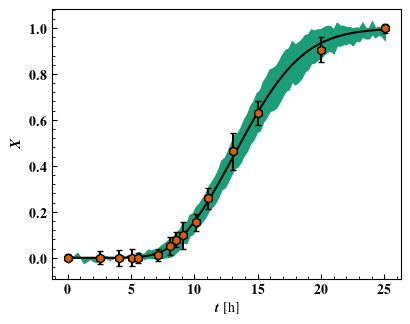

In [39]:
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

    
def sample_posterior_predictive(t: jnp.ndarray,
                                X: jnp.ndarray,
                                tnew: jnp.ndarray,
                                K: float,
                                n: float,
                                t_inc: float,
                                sigma: float,
                                length: float,
                                noise: jnp.ndarray):
     
    k_new = kernel(tnew,tnew,sigma,length,include_noise = False)
    k_pX = kernel(tnew,t,sigma,length,include_noise = False)
    k_XX = kernel(t,t,sigma,length,noise = noise,include_noise = True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    Kernel = k_new - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    mean_offset = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, X))
    mean_eval = model_func(tnew,K,n,t_inc)
    mean = mean_eval
    return mean,mean + jnp.sqrt(jnp.clip(jnp.diag(Kernel), 0.0)) * jax.random.normal(
        rng_key, tnew.shape[:1]
    )


vmap_args  = (posterior_samples[key] for key in ['t_inc','K','n','sigma','l1'])

t_predict = np.linspace(0,t.max(),100)
predictive_means,predictive_samples = vmap(
    lambda t_inc,K,n,sig,l1: sample_posterior_predictive(jnp.array(x),jnp.array(y),t_predict,K,n,t_inc,sig,l1,jnp.array(noise)),
)( *vmap_args)


mean_response = np.mean(predictive_means,axis = 0)
hpdi_posterior = hpdi(predictive_samples,0.95)

fig,ax = default_axis(figsize = (4.5,3.5),
                        xlabel = r'$t$ [h]',
                        ylabel = r'$X$')


ax.fill_between(t_predict/3600, hpdi_posterior[0, :], hpdi_posterior[1, :], color=plt.get_cmap('Dark2')(0.1))
ax.plot(t_predict/3600,mean_response,color = 'k',lw = 1.5,label = 'Mean Response')
ax.errorbar(df['time']/3600,df['X'].to_numpy(),yerr = df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
ax.scatter(df['time']/3600,df['X'],facecolor  = plt.get_cmap('Dark2')(0.2),edgecolor = 'k',
           lw = 1.0,s = 40,marker = 'h',zorder = 1000)